In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os


In [2]:
%matplotlib inline

In [3]:
path1="data/COL208_device1_postdielelectric_FET_2016_05_28_1312.csv"
path2="data/COL211_device2_postdielelectric_FET_2016_05_28_1322.csv"
data1=np.loadtxt(fname=path1,skiprows=1,delimiter=',')
data2=np.loadtxt(fname=path2,skiprows=1,delimiter=',')


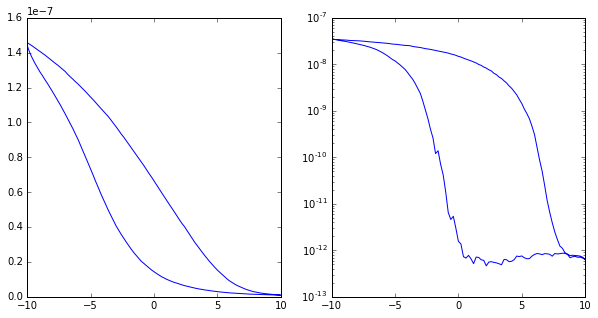

In [4]:
fig=plt.figure(figsize=(10,5))
ax1 = plt.subplot(1,2, 1)
ax2 = plt.subplot(1,2, 2)
ax1.plot(data2[:,0],data1[:,2])
ax2.semilogy(data2[:,0],data2[:,2])




In [5]:
def plotupdown(ax,xdata,ydata):
    half=int(len(xdata)/2)
    ax.plot(xdata[:half],ydata[:half],'b-.',label="start - to + sweep",linewidth=2.0)
    ax.plot(xdata[half:],ydata[half:],'b--',label="+ to - sweep",linewidth=2.0)
    ax.legend()
    
def log_plotupdown(ax,xdata,ydata):
    half=int(len(xdata)/2)
    ax.semilogy(xdata[:half],ydata[:half],'b-.',label="start - to + sweep")
    ax.semilogy(xdata[half:],ydata[half:],'b--',label="+ to - sweep")
    ax.legend()


def plotgradient(ax,xdata,ydata):
    ax2=ax.twinx()
    half=int(len(xdata)/2)
    ax.plot(xdata[:half],ydata[:half],'b-.',label="Up sweep")
    ax2.plot(xdata[:half],np.gradient(ydata[:half]),'r-',label="gradient")
    ax2.legend()
    



def format_axis(ax, title,xlabel,ylabel):
    ax1.set_xlabel(xlabel, fontsize=20)
    ax1.set_ylabel(ylabel, fontsize=20)
    ax1.set_title(title)
    

# mobility calculation using hannahs method 1
where $\mu_{eff} =  \frac{g_mL}{(WV_{DS}C)}$

and $C=\frac{\epsilon_{ox}\epsilon_0}{d_{ox}}$
 and $g_m=\frac{\partial I_D}{\partial V_G}$ in the ohmic region of the transfer curve

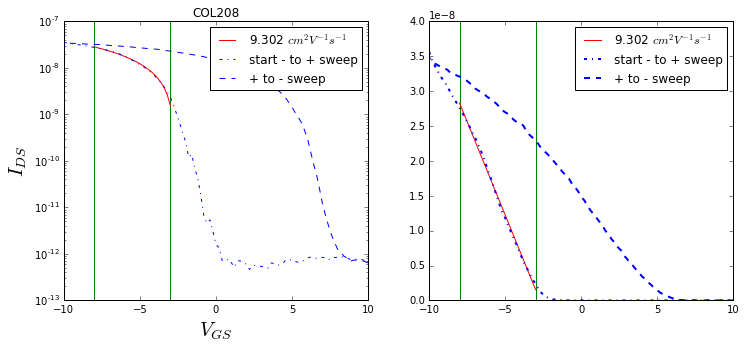

In [6]:
def mobility_calc(gm,oxide_permittivity=3.9,free_permittivity=8.854e-12,
                  L=60e-6 ,W=30e-6,V_ds=0.1,oxide_thickness=300e-9 ):
    """gm is the mutual transconductance which is the gradient of the ohmic region of a transfer characteristic
    curve. L and W are the length and width of the CNT FET channel respectively"""
    
    
    #calculates parallel plate gate capacitance
    C=oxide_permittivity*free_permittivity/oxide_thickness

    #note, these values are in standard si units
    mobility = abs(gm*L/(W*V_ds*C))
    
    mobility_cm=mobility*10000
  

    #print(mobility_cm,"cm^2/Vs")
    return mobility_cm
    
def linefit_xrange(ax, xdata, ydata, x1, x2, color='g'):
    """ax is the axis that you want to plot the resulting line on
    x1 and x2 are the limits that you want to fit between.
    the color is the color of the xlimit vertical lines.
    care should be taken with how to adapt this to fitting to the backsweep of the data"""
    ax.axvline(x1,color = color)
    ax.axvline(x2,color = color)
    startindex = np.where(xdata==x1)[0][0]
    endindex = np.where(xdata==x2)[0][0]
    m,c = np.polyfit(xdata[startindex:endindex+1], ydata[startindex:endindex+1], 1)
    g=mobility_calc(m)
    ax.plot(xdata[startindex:endindex+1], m*xdata[startindex:endindex+1]+c,
                "r-", label=str("%.4g" % g)+" $cm^2V^{-1}s^{-1}$" )#"y = "+str("%.4g" % m)+" x + "+str("%.4g" % c))
    return m


fig=plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2, 1)
ax2 = plt.subplot(1,2, 2)
g1 = linefit_xrange(ax1,data2[:,0],data2[:,2],-8,-3)
g2=linefit_xrange(ax2,data2[:,0],data2[:,2],-8,-3)

log_plotupdown(ax1,data2[:,0],data2[:,2])
plotupdown(ax2,data2[:,0],data2[:,2])
format_axis(ax2,os.path.basename(path1)[:6],"$V_{GS}$","$I_{DS}$")

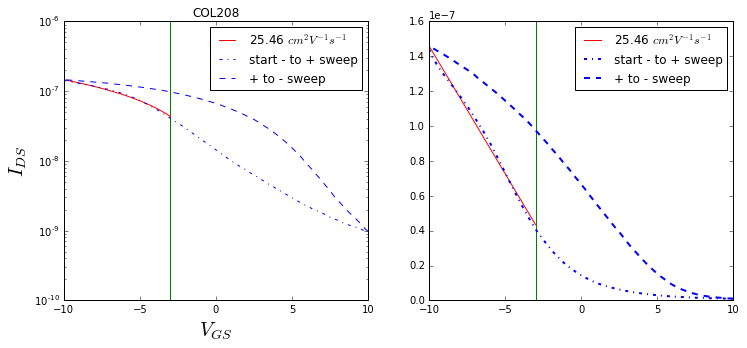

In [7]:
fig=plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2, 1)
ax2 = plt.subplot(1,2, 2)
g1 = linefit_xrange(ax1,data1[:,0],data1[:,2],-10,-3)
g2=linefit_xrange(ax2,data1[:,0],data1[:,2],-10,-3)

log_plotupdown(ax1,data1[:,0],data1[:,2])
plotupdown(ax2,data1[:,0],data1[:,2])
format_axis(ax1,os.path.basename(path1)[:6],"$V_{GS}$","$I_{DS}$")

